#Installation Stuffs

In [ ]:
pwd

'/content'

##GPU Init

In [ ]:
# with tf.device('/device:GPU:0'):

In [ ]:
# %tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
print(tf.__version__)

2.9.2


In [ ]:
!git clone https://github.com/ezaaputra/indonlu.git

!pip install -q emoji
!pip install -q transformers
!pip install -q torch
!pip install -q cuda
!pip install -U -q PyDrive
!pip -q install Sastrawi
!pip -q install xlsxwriter
!pip -q install PySastrawi
!pip -q install pyLDAvis

fatal: destination path 'indonlu' already exists and is not an empty directory.
ERROR: Could not find a version that satisfies the requirement cuda (from versions: none)
ERROR: No matching distribution found for cuda
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


##Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # mount supaya bisa akses file di Drive

Mounted at /content/drive


#Imports

In [ ]:
# Generals
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 5000)
pd.set_option('display.max_columns', 500)

import numpy as np
import re
import random
import torch
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, recall_score, precision_score
from collections import defaultdict
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

In [ ]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings # to modify warnings
warnings.filterwarnings('ignore') # ignoring warnings
sns.set_style('darkgrid')

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = (10, 5)

In [ ]:
# IndoBERT Model
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

In [ ]:
# NLP
import emoji
import nltk
import re, string, unicodedata
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


#Exploratory Data Analysis and Preprocessing

##Read Dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/[dataset-thesis/cleaned-final.csv")
# df = pd.read_csv("cleaned-final.csv", delimiter=';')

In [ ]:
df.head(10)

,Unnamed: 0,id,text,in_retweeted_to_status_id,in_retweeted_to_user_id,in_reply_to_status_id,in_reply_to_user_id,quoted_status_id,entities,place,user_id,user_name,user_screen_name,user_location,user_description,user_verified,user_followers_count,user_friends_count,user_statuses_count,user_created_at,sentiment_type,sentiment_status,cleaned_text,count
0,0,1542831263408848896,RT @pikiran_rakyat: Jerit Sopir Angkot di Kota...,1.542827e+18,58880688.0,NaN,NaN,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,732496239296552961,Emul,Ujang_Emul,"Bandung, Indonesia",NaN,False,37,63,19928,2016-05-17 09:01:27,basic,negative,rt @user: jerit sopir angkot di kota bandung b...,0
1,1,1542703751982895104,Dear @gojekindonesia kayanya pengaturan Maps t...,NaN,NaN,NaN,NaN,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,45828211,Ratri Chibi,Ratrichibi,ratrichibi@gmail.com,"A proud Indonesian who loves to travel, eat, w...",False,10138,1824,95470,2009-06-09 12:45:10,basic,negative,dear @user kayanya pengaturan maps tujuan kamu...,0
2,2,1542811182507360256,Wktu di bus slsai dr ui otw ke hotel di bandun...,NaN,NaN,NaN,NaN,1.542746e+18,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,1731375470,s.adyaningrum,adyadya14,"Palembang, South Sumatera",약속해요 난 널 혼자 두지 않아요 @GFRDofficial,False,864,523,65108,2013-09-05 09:15:06,basic,negative,wktu di bus slsai dr ui otw ke hotel di bandun...,0
3,3,1542753055057510401,@yn_178 @emerson_yuntho @ridwankamil Nah eta t...,NaN,NaN,1.542544e+18,5.485179e+08,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,1202149318829821952,GeowanaPurmana,GeowanaPurmana,NaN,MT ITB 2007 - GMF Aeroasia - JSI Gresik - IGP ...,False,11,33,971,2019-12-04 08:55:16,basic,negative,@user @user @user nah eta transportasi massal....,0
4,4,1543269754252578816,07/02 — - pagi ny keliling apartemen dan itu b...,NaN,NaN,1.543270e+18,1.437109e+18,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,1437109440981782533,♡,sateIliteradio,NaN,"to tell you that i’m sorry, heart",False,0,4,528,2021-09-12 17:42:54,basic,negative,07/02 — - pagi ny keliling apartemen dan itu b...,0
5,5,1543342774916812800,Gw ngerasain pas kuliah di bandung ngandelin a...,NaN,NaN,1.543342e+18,8.777142e+17,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,877714194929336320,Calon Mahasiswa ETH,pejuangkhilaf,yog,"Gapapa hidup susah, yang penting calon engineer",False,113,477,20107,2017-06-22 02:25:46,basic,negative,gw ngerasain pas kuliah di bandung ngandelin a...,0
6,6,1543373509615063041,Bukannya bangun transportasi publik yang memad...,NaN,NaN,NaN,NaN,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,1024115281147310080,a!,oneandover,NaN,Musician | #fanslikenoother 🧡 @mclarenF1,False,119,289,16295,2018-07-31 02:11:24,basic,negative,bukannya bangun transportasi publik yang memad...,0
7,7,1543053087434104832,Kata gua yang mau ngerantau ke Bandung kudu be...,NaN,NaN,NaN,NaN,1.543017e+18,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,1077763826165080064,Lira🦋,lirahaje,NaN,STAY with SKZ ||,False,1535,1539,18007,2018-12-26 03:11:34,basic,negative,kata gua yang mau ngerantau ke bandung kudu be...,0
8,8,1543086171542388736,"@madmedmad_ Hoho iya bang, tapi kalo dibanding...",NaN,NaN,1.543085e+18,5.818629e+07,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,1256989499097100289,naget,nuggetrebuz,NaN,NaN,False,139,353,5227,2020-05-03 16:50:37,basic,negative,"@user hoho iya bang, tapi kalo dibandingin sam...",0
9,9,1543476763678113792,Masalah yg dimaksut karena bus yg membawa romb...,NaN,NaN,NaN,NaN,1.543474e+18,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,1436721891633369094,parfum mahal,parfum_idol,manusia manusia ngeyel,akun debu yg opininya jelek tp sopan (dikit),False,188,214,1426,2021-09-11 16:03:11,basic,negative,masalah yg dimaksut karena bus yg membawa romb...,0


In [ ]:
df = df.iloc[: , 1:] # remove first column

In [ ]:
df.head(5)

,id,text,in_retweeted_to_status_id,in_retweeted_to_user_id,in_reply_to_status_id,in_reply_to_user_id,quoted_status_id,entities,place,user_id,user_name,user_screen_name,user_location,user_description,user_verified,user_followers_count,user_friends_count,user_statuses_count,user_created_at,sentiment_type,sentiment_status,cleaned_text,count
0,1542831263408848896,RT @pikiran_rakyat: Jerit Sopir Angkot di Kota...,1.542827e+18,58880688.0,NaN,NaN,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,732496239296552961,Emul,Ujang_Emul,"Bandung, Indonesia",NaN,False,37,63,19928,2016-05-17 09:01:27,basic,negative,rt @user: jerit sopir angkot di kota bandung b...,0
1,1542703751982895104,Dear @gojekindonesia kayanya pengaturan Maps t...,NaN,NaN,NaN,NaN,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,45828211,Ratri Chibi,Ratrichibi,ratrichibi@gmail.com,"A proud Indonesian who loves to travel, eat, w...",False,10138,1824,95470,2009-06-09 12:45:10,basic,negative,dear @user kayanya pengaturan maps tujuan kamu...,0
2,1542811182507360256,Wktu di bus slsai dr ui otw ke hotel di bandun...,NaN,NaN,NaN,NaN,1.542746e+18,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,1731375470,s.adyaningrum,adyadya14,"Palembang, South Sumatera",약속해요 난 널 혼자 두지 않아요 @GFRDofficial,False,864,523,65108,2013-09-05 09:15:06,basic,negative,wktu di bus slsai dr ui otw ke hotel di bandun...,0
3,1542753055057510401,@yn_178 @emerson_yuntho @ridwankamil Nah eta t...,NaN,NaN,1.542544e+18,5.485179e+08,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,1202149318829821952,GeowanaPurmana,GeowanaPurmana,NaN,MT ITB 2007 - GMF Aeroasia - JSI Gresik - IGP ...,False,11,33,971,2019-12-04 08:55:16,basic,negative,@user @user @user nah eta transportasi massal....,0
4,1543269754252578816,07/02 — - pagi ny keliling apartemen dan itu b...,NaN,NaN,1.543270e+18,1.437109e+18,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,1437109440981782533,♡,sateIliteradio,NaN,"to tell you that i’m sorry, heart",False,0,4,528,2021-09-12 17:42:54,basic,negative,07/02 — - pagi ny keliling apartemen dan itu b...,0


In [ ]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
20946    False
20947    False
20948    False
20949    False
20950    False
Length: 20951, dtype: bool

In [ ]:
df = df.drop_duplicates()

In [ ]:
sizes = df.sentiment_status.value_counts()
print(sizes)

neutral     16030
negative     3096
positive     1825
Name: sentiment_status, dtype: int64


In [ ]:
sizes = sizes.to_frame()

In [ ]:
df_new = sizes.rename(columns={'sentiment_status': 'data_count'}, index={'': 'sentiment_status'})

In [ ]:
df_new

,data_count
neutral,16030
negative,3096
positive,1825


Text(0, 0.5, 'Data Counts')

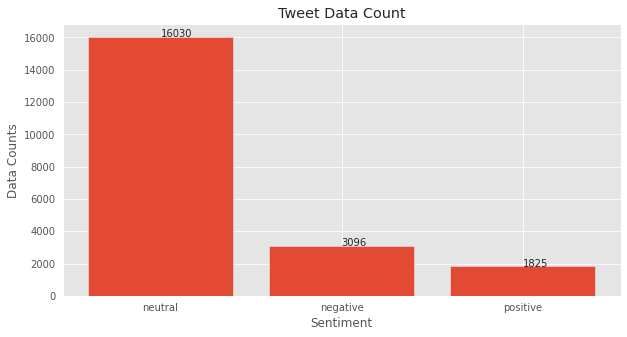

In [ ]:
x = ['neutral', 'negative', 'positive']
y = [16030, 3096, 1825]

plt.bar(x, y)
for a,b in zip(x, y):
    plt.text(a, b, str(b))
plt.title('Tweet Data Count')
plt.xlabel('Sentiment')
plt.ylabel('Data Counts')

##Text Preprocessing

In [ ]:
# Cleaning-Lowercase-Normalisasi-Stopword-Stemming-Tokenizing
# a. Cleaning Text, untuk membersihkan tweet dari simbol, angka, URL, hashtag. Contohnya
# menghilangkan tanda koma (,) pada kalimat “Pengen menyerah, capek dgn smuanya” sehingga
# menjadi “Pengen menyerah capek dgn smuanya”.
# b. Lowering Case, untuk menyeragamkan ke dalam huruf kecil. Contohnya kata “Pengen”
# menjadi “pengen”.
# c. Normalisasi, untuk mengubah kata non-baku menjadi baku. Contohnya kata “pengen”
# menjadi “ingin”, kata “dgn” menjadi “dengan”, kata “smuanya” menjadi “semuanya”.
# d. Stop-word removal, untuk menghilangkan kata yang nilai informasinya rendah. Contohnya
# kata “ada”, “di”, “dan”, “dengan”.
# e. Stemming, untuk mengubah kata menjadi bentuk dasarnya. Contohnya kata “semuanya”
# menjadi “semua”, kata “perasaan” menjadi “rasa”.
# f. Tokenization, untuk memecah kalimat per-token atau kata

with open('/content/drive/MyDrive/[dataset-thesis/combined_slang_words.txt', 'r') as f:
      slang_dict = json.loads(f.read())

# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#Emoji patterns
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

def normalize(str):
  # Define kalimat yang ingin diganti
  sentence = str

  # Iterasi melalui setiap kata dalam kalimat
  for word in sentence.split():
      # Cek apakah kata tersebut ada dalam dictionary slang
      if word in slang_dict:
          # Ganti kata slang dengan kata formalnya
          sentence = sentence.replace(word, slang_dict[word])
  return sentence

def removeStopword(str):
    stop_words = set(stopwords.words('indonesian'))
    word_tokens = word_tokenize(str)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

#remove sentence which contains only one word
def removeSentence(str):
    word = str.split()
    wordCount = len(word)
    if(wordCount <= 1):
        str = ''
    return str

def removeEmojis(text): # remove encoded emojis
    emoji_pattern = re.compile("(:[a-z_]+:)", re.UNICODE)
    str = emoji_pattern.sub("", text)
    return str

def cleaning(str):
    #remove non-ascii
    str = unicodedata.normalize('NFKD', str).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #remove URLs
    str = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', str)
    #remove punctuations
    str = re.sub(r'[^\w]|_',' ',str)
    #remove @username
    str = re.sub('@[^\s]+', '',str)
    #remove digit from string
    str = re.sub("\S*\d\S*", "", str).strip()
    #remove digit or numbers
    str = re.sub(r"\b\d+\b", " ", str)
    #to lowercase
    str = str.lower()
    #Remove additional white spaces
    str = re.sub('[\s]+', ' ', str)
    # remove hashtag
    str = re.sub(r'#([^\s]+)', '', str)
    # Remove simbol, angka dan karakter aneh
    str = re.sub(r"[.,:;+!\-_<^/=?\"'\(\)\d\*]", " ", str)
    # trim
    str = str.strip('\'"')
    #replace consecutive non-ASCII characters with a space
    str = re.sub(r'[^\x00-\x7F]+', '', str)
    # remove specific words
    to_remove = ['user', 'httpurl', 'anot', 'deh' 'crying', 'crying', 'iya', 'banget',
                 'retweet', 'loudly', 'face', 'with', 'wayv', "thumbs", "nct", "dream",
                 "wk", "warning", "yuk", 'wib', 'sweat', 'muhammad', 'sleeper', 'beaming',
                 'laughing', 'rolling', 'smiling', 'eyes', 'grinning', 'skin', 'hands', 'folded', 'kpop', 'idol']
    str = re.sub("|".join(to_remove), "", str)
    # remove specific patterns
    strings_to_remove = r'\b(rt|wk|gk|ga)\b'
    str = re.sub(strings_to_remove, '', str, flags=re.IGNORECASE)
    # remove emojis from tweet
    str = emoji_pattern.sub(r'', str)
    return str

# def stem(str):
#   # create stemmer
#   factory = StemmerFactory()
#   stemmer = factory.create_stemmer()

#   # stemming process
#   output   = stemmer.stem(str)
#   return output

def preprocessing(str):
    str = removeSentence(str)
    str = removeEmojis(str)
    str = cleaning(str)
    str = normalize(str)
    str = cleaning(str)
    str = removeStopword(str)
    # str = stem(str)

    return str

In [ ]:
# Apply the preprocessing function to the 'text' column
with tf.device('/device:GPU:0'):
  df['cleaned_text'] = df['cleaned_text'].apply(preprocessing)

In [ ]:
df['cleaned_text'].head(20)

0     jerit sopir kota bandung beli pealite mesti pa...
1     dear kayaknya pengaturan maps tujuan dibenerin...
2     tu bus selesai dr ui odan the way sedadang jal...
3     eta transportasi massal keluartidak tidakrut b...
4     pagi nya keliling apartemen mencerahkn pagiku ...
5     ngerasain pas kuliah bandung ngandelin kegiata...
6     bangun transportasi publik memadai menjanau ko...
7     ngerantau bandung belajar sunda anjing teman s...
8     hoho bang dibandingin bandung mah tarif terint...
9     dimaksut bus membawa rombongan member terjebak...
10          kasian member semarang bandung bus pleading
11    menangis sedih rombongan tasik manasik haji ba...
12    menangis sedih rombongan tasik manasik haji ba...
13    kasian fans ng ssudah pas gramed kedengeran su...
14    istirahat bandung capek bogor bandung motor me...
15    blue hea plis ng suka menunggu anutan daerah s...
16    istirahat bandung capek bogor bandung motor me...
17    lihat bus tasik parkir halaman mall sumpah

#Word Unique

In [ ]:
from collections import Counter
results = Counter()
df['cleaned_text'].str.lower().str.split().apply(results.update)
print(len(results))
print(results)

24671
Counter({'transjakarta': 6451, 'bus': 4606, 'bandung': 4273, 'jakarta': 4208, 'trans': 1411, 'rute': 1330, 'jam': 1295, 'kota': 1269, 'kak': 1250, 'jalan': 1219, 'kasih': 1219, 'terima': 1151, 'pakai': 1143, 'smiling': 1025, 'halte': 1002, 'the': 945, 'nya': 913, 'sih': 856, 'on': 838, 'beroperasi': 838, 'orang': 831, 'anutan': 826, 'transportasi': 810, 'tears': 774, 'layanan': 763, 'kakak': 748, 'kereta': 720, 'floor': 713, 'transjakaa': 699, 'of': 695, 'hands': 664, 'jakaa': 654, 'bbm': 643, 'joy': 641, 'malam': 619, 'tj': 614, 'deh': 613, 'ng': 609, 'mobil': 604, 'pas': 580, 'pulang': 577, 'lihat': 560, 'tarif': 560, 'amp': 555, 'terang': 544, 'tone': 541, 'perempuan': 539, 'skin': 538, 'informasi': 535, 'koridor': 517, 'harga': 515, 'eyes': 514, 'kendaraan': 498, 'heart': 486, 'bis': 477, 'tuh': 473, 'hai': 472, 'up': 462, 'indonesia': 460, 'bikin': 455, 'teman': 453, 'keliling': 448, 'pelanggan': 447, 'folded': 437, 'jalur': 426, 'grinning': 419, 'macet': 410, 'min': 407, 'd

In [ ]:
print(results.most_common(200))

[('transjakarta', 6451), ('bus', 4606), ('bandung', 4273), ('jakarta', 4208), ('trans', 1411), ('rute', 1330), ('jam', 1295), ('kota', 1269), ('kak', 1250), ('jalan', 1219), ('kasih', 1219), ('terima', 1151), ('pakai', 1143), ('smiling', 1025), ('halte', 1002), ('the', 945), ('nya', 913), ('sih', 856), ('on', 838), ('beroperasi', 838), ('orang', 831), ('anutan', 826), ('transportasi', 810), ('tears', 774), ('layanan', 763), ('kakak', 748), ('kereta', 720), ('floor', 713), ('transjakaa', 699), ('of', 695), ('hands', 664), ('jakaa', 654), ('bbm', 643), ('joy', 641), ('malam', 619), ('tj', 614), ('deh', 613), ('ng', 609), ('mobil', 604), ('pas', 580), ('pulang', 577), ('lihat', 560), ('tarif', 560), ('amp', 555), ('terang', 544), ('tone', 541), ('perempuan', 539), ('skin', 538), ('informasi', 535), ('koridor', 517), ('harga', 515), ('eyes', 514), ('kendaraan', 498), ('heart', 486), ('bis', 477), ('tuh', 473), ('hai', 472), ('up', 462), ('indonesia', 460), ('bikin', 455), ('teman', 453), (

In [ ]:
with open("results.txt", 'w') as f:
    for k,v in  results.most_common(50000):
        f.write( "{} {}\n".format(k,v) )

##Plot Label Proportions

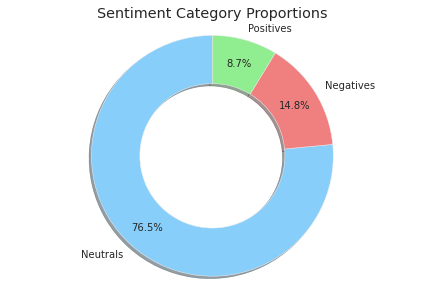

In [ ]:
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%',
           startangle = angle, pctdistance=0.8, explode = explode,
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')
    plt.tight_layout()

# Plot arguments
sizes = df.sentiment_status.value_counts()
labels = ['Neutrals', 'Negatives', 'Positives']
colors = ['lightskyblue', 'lightcoral', 'lightgreen']
explode = (0,0,0)

# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Sentiment Category Proportions')

plt.show()

In [ ]:
df_new = df[['cleaned_text','sentiment_status']].copy()

In [ ]:
df_new.head(5)

,cleaned_text,sentiment_status
0,jerit sopir kota bandung beli pealite mesti pa...,negative
1,dear kayaknya pengaturan maps tujuan dibenerin...,negative
2,tu bus selesai dr ui odan the way sedadang jal...,negative
3,eta transportasi massal keluartidak tidakrut b...,negative
4,pagi nya keliling apartemen mencerahkn pagiku ...,negative


In [ ]:
df_new = df_new[df_new['cleaned_text'].str.strip().ne('')]

In [ ]:
# remove the current index and replace with default index
# df_new = df_new.reset_index(drop=True)

In [ ]:
# df_new = df_new.iloc[:, 2:]

In [ ]:
df_new

,cleaned_text,sentiment_status
0,jerit sopir kota bandung beli pealite mesti pa...,negative
1,dear kayaknya pengaturan maps tujuan dibenerin...,negative
2,tu bus selesai dr ui odan the way sedadang jal...,negative
3,eta transportasi massal keluartidak tidakrut b...,negative
4,pagi nya keliling apartemen mencerahkn pagiku ...,negative
...,...,...
20946,thought balloon aaa pengen transjakaa,neutral
20947,transjakarta kenap ketemu coba cuk,neutral
20948,gambaran transjakarta,neutral
20949,ootd cari slingbag nihh bagus,neutral


In [ ]:
df_new.to_csv('text-and-sentiment.csv')

#Processing

##Split Dataset

In [ ]:
# train val split
train_set, val_set = train_test_split(df_new, test_size=0.3, stratify=df_new.sentiment_status, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.sentiment_status, random_state=1)

print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

# export to tsv
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

Train shape: (14511, 2)
Val shape: (4166, 2)
Test shape: (2053, 2)


##BERT

###BERT - Common Functions

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

# Set random seed
set_seed(27)

###BERT - Configs

In [ ]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

# Struktur model
print(model)

# Jumlah parameter
print(count_param(model))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

###BERT - Data Preps

In [ ]:
train_dataset_path = '/content/train_set.tsv'
valid_dataset_path = '/content/val_set.tsv'
test_dataset_path = '/content/test_set.tsv'

# fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


###BERT - Training

In [ ]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

# Train
with tf.device('/device:GPU:0'):
  n_epochs = 15
  history = defaultdict(list)
  for epoch in range(n_epochs):
      model.train()
      torch.set_grad_enabled(True)

      total_train_loss = 0
      list_hyp_train, list_label = [], []

      train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
      for i, batch_data in enumerate(train_pbar):
          # Forward model
          loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

          # Update model
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          tr_loss = loss.item()
          total_train_loss = total_train_loss + tr_loss

          # Hitung skor train metrics
          list_hyp_train += batch_hyp
          list_label += batch_label

          train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
              total_train_loss/(i+1), get_lr(optimizer)))

      metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
      print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
          total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

      # save train acc for learning curve
      history['train_acc'].append(metrics['ACC'])

      # Evaluate di validation set
      model.eval()
      torch.set_grad_enabled(False)

      total_loss, total_correct, total_labels = 0, 0, 0
      list_hyp, list_label = [], []

      pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
      for i, batch_data in enumerate(pbar):
          batch_seq = batch_data[-1]
          loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

          # Hitung total loss
          valid_loss = loss.item()
          total_loss = total_loss + valid_loss

          # Hitung skor evaluation metrics
          list_hyp += batch_hyp
          list_label += batch_label
          metrics = document_sentiment_metrics_fn(list_hyp, list_label)

          pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

      metrics = document_sentiment_metrics_fn(list_hyp, list_label)
      print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
          total_loss/(i+1), metrics_to_string(metrics)))

      # save validation acc for learning curve
      history['val_acc'].append(metrics['ACC'])

(Epoch 1) TRAIN LOSS:0.5508 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.74it/s]


(Epoch 1) TRAIN LOSS:0.5508 ACC:0.79 F1:0.52 REC:0.48 PRE:0.65 LR:0.00000300


VALID LOSS:0.4335 ACC:0.83 F1:0.69 REC:0.65 PRE:0.74: 100%|██████████| 131/131 [00:08<00:00, 15.95it/s]


(Epoch 1) VALID LOSS:0.4335 ACC:0.83 F1:0.69 REC:0.65 PRE:0.74


(Epoch 2) TRAIN LOSS:0.3976 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.88it/s]


(Epoch 2) TRAIN LOSS:0.3976 ACC:0.84 F1:0.71 REC:0.68 PRE:0.77 LR:0.00000300


VALID LOSS:0.4379 ACC:0.83 F1:0.70 REC:0.71 PRE:0.70: 100%|██████████| 131/131 [00:08<00:00, 15.78it/s]


(Epoch 2) VALID LOSS:0.4379 ACC:0.83 F1:0.70 REC:0.71 PRE:0.70


(Epoch 3) TRAIN LOSS:0.3321 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.85it/s]


(Epoch 3) TRAIN LOSS:0.3321 ACC:0.87 F1:0.77 REC:0.74 PRE:0.81 LR:0.00000300


VALID LOSS:0.4303 ACC:0.83 F1:0.68 REC:0.65 PRE:0.74: 100%|██████████| 131/131 [00:08<00:00, 15.70it/s]


(Epoch 3) VALID LOSS:0.4303 ACC:0.83 F1:0.68 REC:0.65 PRE:0.74


(Epoch 4) TRAIN LOSS:0.2811 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.77it/s]


(Epoch 4) TRAIN LOSS:0.2811 ACC:0.89 F1:0.81 REC:0.79 PRE:0.84 LR:0.00000300


VALID LOSS:0.4553 ACC:0.82 F1:0.72 REC:0.74 PRE:0.70: 100%|██████████| 131/131 [00:08<00:00, 15.82it/s]


(Epoch 4) VALID LOSS:0.4553 ACC:0.82 F1:0.72 REC:0.74 PRE:0.70


(Epoch 5) TRAIN LOSS:0.2279 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.81it/s]


(Epoch 5) TRAIN LOSS:0.2279 ACC:0.92 F1:0.86 REC:0.84 PRE:0.88 LR:0.00000300


VALID LOSS:0.4686 ACC:0.84 F1:0.71 REC:0.69 PRE:0.74: 100%|██████████| 131/131 [00:08<00:00, 15.88it/s]


(Epoch 5) VALID LOSS:0.4686 ACC:0.84 F1:0.71 REC:0.69 PRE:0.74


(Epoch 6) TRAIN LOSS:0.1857 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.86it/s]


(Epoch 6) TRAIN LOSS:0.1857 ACC:0.93 F1:0.89 REC:0.88 PRE:0.90 LR:0.00000300


VALID LOSS:0.5231 ACC:0.83 F1:0.71 REC:0.70 PRE:0.72: 100%|██████████| 131/131 [00:08<00:00, 15.96it/s]


(Epoch 6) VALID LOSS:0.5231 ACC:0.83 F1:0.71 REC:0.70 PRE:0.72


(Epoch 7) TRAIN LOSS:0.1453 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.79it/s]


(Epoch 7) TRAIN LOSS:0.1453 ACC:0.95 F1:0.92 REC:0.91 PRE:0.93 LR:0.00000300


VALID LOSS:0.5278 ACC:0.83 F1:0.71 REC:0.70 PRE:0.72: 100%|██████████| 131/131 [00:08<00:00, 15.59it/s]


(Epoch 7) VALID LOSS:0.5278 ACC:0.83 F1:0.71 REC:0.70 PRE:0.72


(Epoch 8) TRAIN LOSS:0.1138 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.76it/s]


(Epoch 8) TRAIN LOSS:0.1138 ACC:0.96 F1:0.93 REC:0.93 PRE:0.94 LR:0.00000300


VALID LOSS:0.5926 ACC:0.83 F1:0.71 REC:0.70 PRE:0.73: 100%|██████████| 131/131 [00:08<00:00, 15.86it/s]


(Epoch 8) VALID LOSS:0.5926 ACC:0.83 F1:0.71 REC:0.70 PRE:0.73


(Epoch 9) TRAIN LOSS:0.0989 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.82it/s]


(Epoch 9) TRAIN LOSS:0.0989 ACC:0.97 F1:0.94 REC:0.94 PRE:0.95 LR:0.00000300


VALID LOSS:0.6228 ACC:0.83 F1:0.71 REC:0.69 PRE:0.73: 100%|██████████| 131/131 [00:08<00:00, 16.03it/s]


(Epoch 9) VALID LOSS:0.6228 ACC:0.83 F1:0.71 REC:0.69 PRE:0.73


(Epoch 10) TRAIN LOSS:0.0789 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.79it/s]


(Epoch 10) TRAIN LOSS:0.0789 ACC:0.97 F1:0.95 REC:0.95 PRE:0.96 LR:0.00000300


VALID LOSS:0.6761 ACC:0.83 F1:0.71 REC:0.70 PRE:0.71: 100%|██████████| 131/131 [00:08<00:00, 15.63it/s]


(Epoch 10) VALID LOSS:0.6761 ACC:0.83 F1:0.71 REC:0.70 PRE:0.71


(Epoch 11) TRAIN LOSS:0.0687 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.68it/s]


(Epoch 11) TRAIN LOSS:0.0687 ACC:0.98 F1:0.96 REC:0.96 PRE:0.97 LR:0.00000300


VALID LOSS:0.7140 ACC:0.82 F1:0.70 REC:0.71 PRE:0.69: 100%|██████████| 131/131 [00:08<00:00, 15.93it/s]


(Epoch 11) VALID LOSS:0.7140 ACC:0.82 F1:0.70 REC:0.71 PRE:0.69


(Epoch 12) TRAIN LOSS:0.0599 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.90it/s]


(Epoch 12) TRAIN LOSS:0.0599 ACC:0.98 F1:0.97 REC:0.97 PRE:0.97 LR:0.00000300


VALID LOSS:0.7242 ACC:0.83 F1:0.71 REC:0.71 PRE:0.70: 100%|██████████| 131/131 [00:08<00:00, 15.87it/s]


(Epoch 12) VALID LOSS:0.7242 ACC:0.83 F1:0.71 REC:0.71 PRE:0.70


(Epoch 13) TRAIN LOSS:0.0544 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.82it/s]


(Epoch 13) TRAIN LOSS:0.0544 ACC:0.98 F1:0.97 REC:0.97 PRE:0.97 LR:0.00000300


VALID LOSS:0.7500 ACC:0.82 F1:0.70 REC:0.71 PRE:0.70: 100%|██████████| 131/131 [00:08<00:00, 15.99it/s]


(Epoch 13) VALID LOSS:0.7500 ACC:0.82 F1:0.70 REC:0.71 PRE:0.70


(Epoch 14) TRAIN LOSS:0.0460 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.89it/s]


(Epoch 14) TRAIN LOSS:0.0460 ACC:0.99 F1:0.98 REC:0.97 PRE:0.98 LR:0.00000300


VALID LOSS:0.7832 ACC:0.83 F1:0.70 REC:0.69 PRE:0.71: 100%|██████████| 131/131 [00:08<00:00, 16.04it/s]


(Epoch 14) VALID LOSS:0.7832 ACC:0.83 F1:0.70 REC:0.69 PRE:0.71


(Epoch 15) TRAIN LOSS:0.0482 LR:0.00000300: 100%|██████████| 454/454 [00:38<00:00, 11.82it/s]


(Epoch 15) TRAIN LOSS:0.0482 ACC:0.99 F1:0.97 REC:0.97 PRE:0.98 LR:0.00000300


VALID LOSS:0.7656 ACC:0.82 F1:0.70 REC:0.71 PRE:0.70: 100%|██████████| 131/131 [00:08<00:00, 15.56it/s]


(Epoch 15) VALID LOSS:0.7656 ACC:0.82 F1:0.70 REC:0.71 PRE:0.70


In [ ]:
import torch
torch.save(model, '/content/drive/MyDrive/[dataset-thesis/model')

In [ ]:
saved_model = torch.load('/content/drive/MyDrive/[dataset-thesis/model')

###Learning Curve

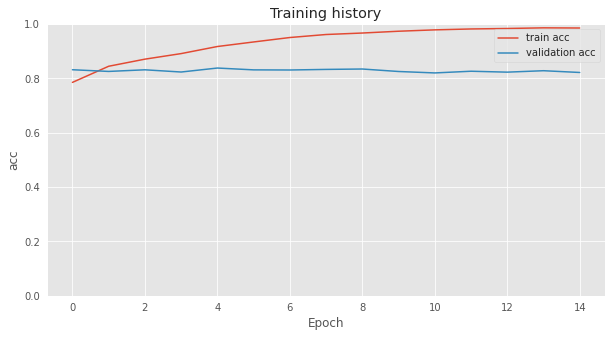

In [ ]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['review_text', 'category'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result.csv', index=False)

###Prediksi Test Set

In [ ]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

100%|██████████| 65/65 [00:02<00:00, 24.00it/s]


In [ ]:
# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['review_text', 'category'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('test result.csv', index=False)

#Evaluate

In [ ]:
val_real = val_df.category
val_pred = val_df.pred

test_real = test_df.category
test_pred = test_df.pred

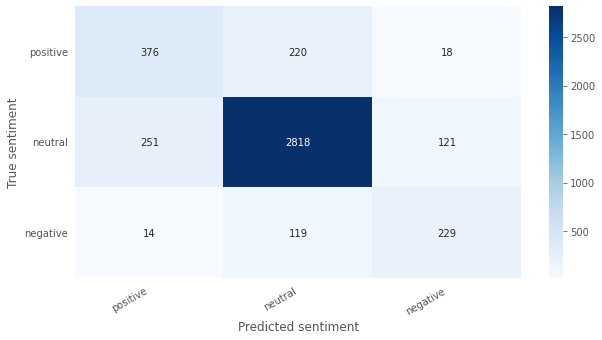

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(val_real, val_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.59      0.61      0.60       614
     neutral       0.89      0.88      0.89      3190
    negative       0.62      0.63      0.63       362

    accuracy                           0.82      4166
   macro avg       0.70      0.71      0.70      4166
weighted avg       0.82      0.82      0.82      4166



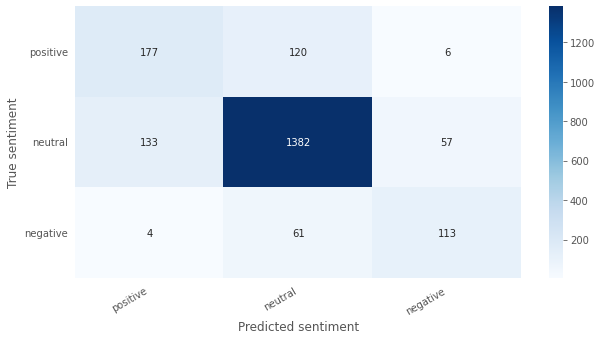

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(test_real, test_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.56      0.58      0.57       303
     neutral       0.88      0.88      0.88      1572
    negative       0.64      0.63      0.64       178

    accuracy                           0.81      2053
   macro avg       0.70      0.70      0.70      2053
weighted avg       0.82      0.81      0.82      2053



#LDA Topic

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# load your dataset of text documents
texts = df_new['cleaned_text'].tolist()

In [ ]:
# preprocess the texts by tokenizing them
texts = [nltk.word_tokenize(text) for text in texts]

# create a dictionary from the texts
dictionary = Dictionary(texts)

# convert the texts into a bag-of-words format
corpus = [dictionary.doc2bow(text) for text in texts]

# train the LDA model
num_topics = 3

with tf.device('/device:GPU:0'):
  ldamodel = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
# print top 10 keywords for each topic
for topic_id, topic in ldamodel.print_topics(num_topics=num_topics, num_words=20):
    print("Topic", topic_id+1, ":", topic)

Topic 1 : 0.025*"jakarta" + 0.020*"transjakarta" + 0.011*"bus" + 0.011*"the" + 0.010*"on" + 0.009*"perempuan" + 0.008*"idol" + 0.008*"floor" + 0.008*"trans" + 0.007*"bandung" + 0.007*"keliling" + 0.007*"somasi" + 0.006*"kpop" + 0.006*"es" + 0.005*"tj" + 0.005*"indo" + 0.005*"deh" + 0.005*"terpikirkan" + 0.004*"smiling" + 0.004*"kakak"
Topic 2 : 0.062*"transjakarta" + 0.014*"kakak" + 0.011*"le" + 0.011*"kak" + 0.010*"es" + 0.009*"minerale" + 0.009*"kasih" + 0.009*"terima" + 0.008*"rute" + 0.008*"perempuan" + 0.007*"layanan" + 0.007*"hands" + 0.007*"beroperasi" + 0.007*"terang" + 0.007*"tone" + 0.007*"skin" + 0.006*"anya" + 0.006*"kepanasan" + 0.006*"arief" + 0.006*"tji"
Topic 3 : 0.026*"bus" + 0.018*"bandung" + 0.014*"jakarta" + 0.011*"tears" + 0.011*"transjakarta" + 0.010*"of" + 0.009*"joy" + 0.009*"jalan" + 0.008*"kota" + 0.007*"pakai" + 0.005*"jakaa" + 0.005*"bank" + 0.005*"anutan" + 0.005*"sih" + 0.004*"orang" + 0.004*"nya" + 0.004*"ng" + 0.004*"teman" + 0.004*"halte" + 0.004*"trans

In [ ]:
from gensim.test.utils import datapath

# Save the LDA model to a file
ldamodel.save("/content/drive/MyDrive/[dataset-thesis/model-3topic.gensim")

# load the saved LDA model
# loaded_model = gensim.models.ldamodel.LdaModel.load(datapath("model.gensim"))

/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
# create a mapping of topics to sentiments
topic_sentiment_mapping = {0: 'positive', 1: 'negative', 2: 'neutral'}

In [ ]:
# infer the topic distribution for each text in the dataset
tekslist = []
for i, text in enumerate(texts):
    bow = dictionary.doc2bow(text)
    topic_probs = ldamodel.get_document_topics(bow)
    topic_probs = sorted(topic_probs, key=lambda x: x[1], reverse=True)
    most_likely_topic = topic_probs[0][0]
    sentiment = topic_sentiment_mapping[most_likely_topic]
    num = str(i+1)
    teks = "Text " + num + " is most likely " + str(sentiment) + " and most likely fit in topic number " + str(most_likely_topic)
    tekslist.append(teks)

In [ ]:
topiclist = []
for string in tekslist:
    match = re.search(r'number (\d+)', string)
    if match:
        # print(match.group(1))
        topiclist.append(match.group(1))
    else:
        print("Tidak ditemukan")

In [ ]:
df = pd.DataFrame(topiclist)

# saving the dataframe
df.to_csv('topicnum_' + str(num_topics) + '.csv')

In [ ]:
# concat topic and df_new

df1 = pd.read_csv('text-and-sentiment.csv')
df2 = pd.read_csv('topicnum_' + str(num_topics) + '.csv')

# concatenate the two dataframes along the cols
merged_df = pd.concat([df1, df2], axis=1)

In [ ]:
merged_df
# merged_df = merged_df.iloc[:, [2, 3, 4]]

,Unnamed: 0,cleaned_text,sentiment_status,Unnamed: 0,0
0,0,jerit sopir kota bandung beli pealite mesti pa...,negative,0,2
1,1,dear kayaknya pengaturan maps tujuan dibenerin...,negative,1,0
2,2,tu bus selesai dr ui odan the way sedadang jal...,negative,2,2
3,3,eta transportasi massal keluartidak tidakrut b...,negative,3,2
4,4,pagi nya keliling apartemen mencerahkn pagiku ...,negative,4,0
...,...,...,...,...,...
20705,20946,thought balloon aaa pengen transjakaa,neutral,20705,2
20706,20947,transjakarta kenap ketemu coba cuk,neutral,20706,0
20707,20948,gambaran transjakarta,neutral,20707,0
20708,20949,ootd cari slingbag nihh bagus,neutral,20708,1


In [ ]:
merged_df.to_csv("text-topic-sentiment-3-topic.csv")

##Intertopic Distance Map

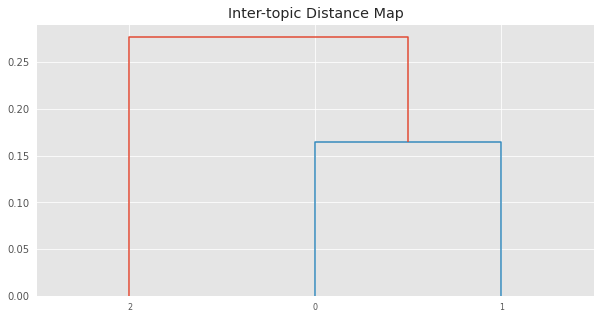

In [ ]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# calculate coherence score for each topic
coherence_model = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_scores = coherence_model.get_coherence_per_topic()

# generate dendrogram
Z = sch.linkage(coherence_scores, method='ward')
plt.figure(figsize=(10,5))
sch.dendrogram(Z, leaf_rotation=0, leaf_font_size=8, orientation='top')
plt.title("Inter-topic Distance Map")
plt.show()

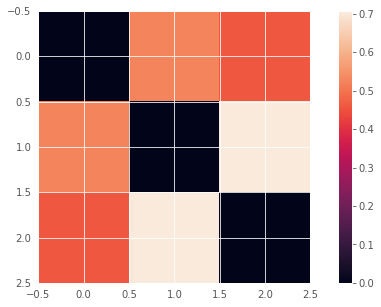

In [ ]:
import gensim
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load the saved LDA model
# lda_model = gensim.models.ldamodel.LdaModel.load('path/to/model')

# Calculate the intertopic distance matrix
topics = ldamodel.state.get_lambda()
distance_matrix = 1 - cosine_similarity(topics)

# Plot the intertopic distance matrix using matplotlib
plt.imshow(distance_matrix)
plt.colorbar()
plt.show()

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Load the saved LDA model
# lda_model = gensim.models.ldamodel.LdaModel.load('path/to/model')

# Prepare the data for visualization
vis_data = gensimvis.prepare(ldamodel, corpus, dictionary)

# Plot the intertopic distance map
pyLDAvis.display(vis_data)
pyLDAvis.save_html(vis_data, 'lda-gensim-try-31-jan-3-topic.html')